In [1]:
%load_ext autoreload

%autoreload 2 

## Libraries

In [2]:
import os
import torch
import numpy as np
from data import *
from model import *
from train import *
from utils import * 
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, LambdaLR

## Getting a CUDA Device

In [3]:
device = get_device()
print(f"Current device: {device}")

Current device: cuda


## Training Dataset Specifications

In [4]:
augment=True
mode = 'Training'
preprocess = True
default_tranforms =  T.ToTensor()
root_dir = os.path.join(os.getcwd(), 'dataset')
dataset_mean_file = os.path.join(os.getcwd(), 'mean_and_std.txt')

##  Dataset Instance

In [5]:
dataset = BrainTumorDataset(root_dir=root_dir, 
                            mode=mode,
                            split=True,
                            preprocess=preprocess,
                            transforms=default_tranforms,)

## Class Distribution of the Dataset

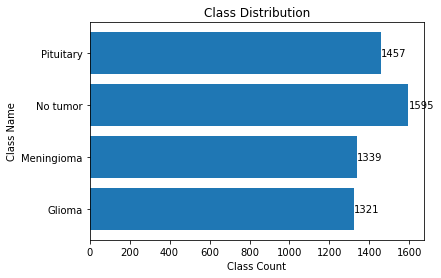

In [6]:
dataset.plot_data_distribution()

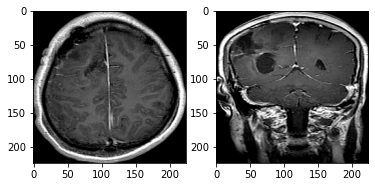

In [7]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(dataset[220][0].permute(1, -1, 0))
axarr[1].imshow(dataset[10][0].permute(1, -1, 0))

## Test Dataset Specification

In [8]:
test_mode='Testing'

In [9]:
test_dataset = BrainTumorDataset(root_dir=root_dir, mode=test_mode,preprocess=preprocess,transforms=default_tranforms)

## Class Distribution of the Test Dataset 

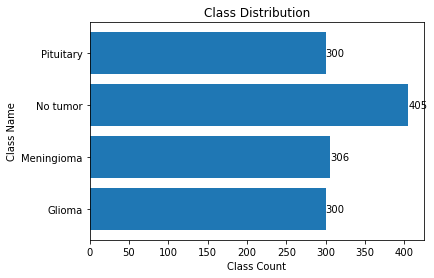

In [10]:
test_dataset.plot_data_distribution()

## Split Specifications

In [11]:
num_samples = len(dataset)
train_samples, val_samples = split_samples(num_samples=num_samples, ratio=0.60)
print(f"num_samples: {num_samples}, \ntrain_samples : {train_samples},\nval_samples : {val_samples}")


num_samples: 5712, 
train_samples : 3427,
val_samples : 2285


## Split Dataset into Training and Validation Sets

In [12]:
train_set, val_set = dataset.split_data(ratio=0.6, augment=True)

## Class Distribution of the Training Set 

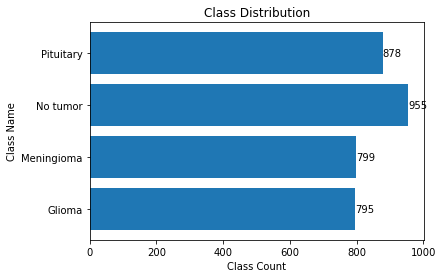

In [13]:
train_set.plot_data_distribution()

## Class Distribution of the Validation Set 

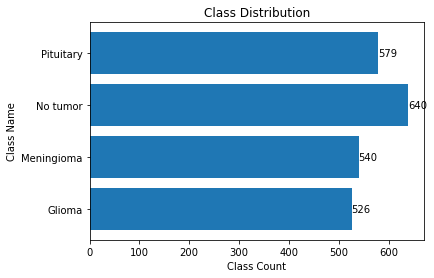

In [14]:
val_set.plot_data_distribution()

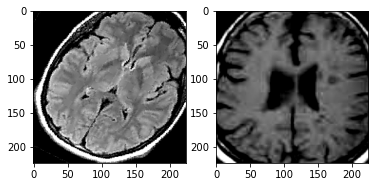

In [15]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(train_set[10][0].permute(1, -1, 0))
axarr[1].imshow(val_set[10][0].permute(1, -1, 0))

In [18]:
from torch.utils.data import WeightedRandomSampler
weights = train_set.class_weights_for_sampler(device=None)
sampler = WeightedRandomSampler(weights=weights, num_samples=train_samples, replacement=True)


In [21]:
train_loader = DataLoader(train_set, batch_size = 128, sampler=sampler, shuffle=False, num_workers=4, collate_fn=None,pin_memory=True)
validation_loader = DataLoader(val_set, batch_size = 256, shuffle=True, num_workers=4, collate_fn=None,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle=True, num_workers=4, collate_fn=None,pin_memory=True)

## Calculating the Mean and Standard Deviation of the Data Subset

In [22]:
mean, std = get_mean_and_std(train_loader, dataset_mean_file, redo=False)

In [23]:
print(mean, std)

tensor([0.3228, 0.3228, 0.3229]) tensor([0.2816, 0.2816, 0.2816])


## Set the Data Transforms to Apply Normalization

In [24]:
new_transforms = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

In [25]:
train_set.set_transforms(new_transforms)
val_set.set_transforms(new_transforms)
test_dataset.set_transforms(new_transforms)

## Images After Normalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


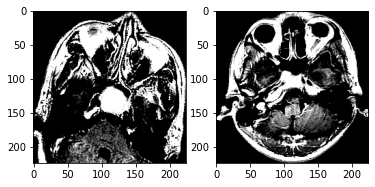

In [26]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(train_set[250][0].permute(1, 2, 0))
axarr[1].imshow(test_dataset[3][0].permute(1, 2, 0))

## The specifications of the BrainTumorClassifer Model

In [27]:
in_channels = 3
num_classes = 4
bias=False

In [28]:
model = BrainTumorClasssifer(in_channels=in_channels, num_classes=num_classes, bias=bias)

## Training Specifications

In [29]:
learning_rate = 1e-3
weight_decay = 1e-2
momentum = 0.99
epochs=45

In [30]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True, betas=(0.9, 0.999))

In [31]:
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [32]:
weights = dataset.class_weights()

In [33]:

criterion = torch.nn.CrossEntropyLoss(weight=None)

In [34]:
torch.backends.cudnn.benchmark = True

In [35]:
total_loss, epoch_times, accuracies_train, accuracies_validation = train(model, optimizer, train_loader, validation_loader, criterion, epochs,scheduler=scheduler, device=device)

Current device: cuda


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]

Evaluating epoch...


Epoch: 0 | Loss: 27.04 | Train acc: 58.07 | Val acc: 74.27 | Val_loss: 6.06149834394455 | lr: 0.001 | Runtime: 74.74 seconds


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]

Evaluating epoch...


Epoch: 1 | Loss: 15.93 | Train acc: 77.36 | Val acc: 84.64 | Val_loss: 3.932824671268463 | lr: 0.001 | Runtime: 59.95 seconds


100%|██████████| 27/27 [00:38<00:00,  1.41s/it]

Evaluating epoch...


Epoch: 2 | Loss: 11.99 | Train acc: 83.57 | Val acc: 80.44 | Val_loss: 4.477646738290787 | lr: 0.001 | Runtime: 60.06 seconds


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]

Evaluating epoch...


Epoch: 3 | Loss: 11.01 | Train acc: 84.77 | Val acc: 87.66 | Val_loss: 3.1263996064662933 | lr: 0.001 | Runtime: 59.88 seconds


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]

Evaluating epoch...


Epoch: 4 | Loss: 8.19 | Train acc: 89.03 | Val acc: 91.20 | Val_loss: 2.2932200580835342 | lr: 0.001 | Runtime: 61.32 seconds


100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

Evaluating epoch...


Epoch: 5 | Loss: 7.28 | Train acc: 89.90 | Val acc: 91.38 | Val_loss: 2.237635090947151 | lr: 0.001 | Runtime: 61.62 seconds


100%|██████████| 27/27 [00:40<00:00,  1.48s/it]

Evaluating epoch...


Epoch: 6 | Loss: 6.65 | Train acc: 91.22 | Val acc: 88.05 | Val_loss: 3.072273015975952 | lr: 0.001 | Runtime: 62.63 seconds


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

Evaluating epoch...


Epoch: 7 | Loss: 6.56 | Train acc: 91.36 | Val acc: 90.33 | Val_loss: 2.448495402932167 | lr: 0.001 | Runtime: 62.13 seconds


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

Evaluating epoch...


Epoch: 8 | Loss: 6.17 | Train acc: 91.19 | Val acc: 92.08 | Val_loss: 1.9546749144792557 | lr: 0.001 | Runtime: 62.06 seconds


100%|██████████| 27/27 [00:38<00:00,  1.43s/it]

Evaluating epoch...


Epoch: 9 | Loss: 5.07 | Train acc: 93.17 | Val acc: 94.05 | Val_loss: 1.6197042390704155 | lr: 0.001 | Runtime: 62.00 seconds


100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

Evaluating epoch...


Epoch: 10 | Loss: 4.06 | Train acc: 94.69 | Val acc: 93.70 | Val_loss: 1.6880019456148148 | lr: 0.001 | Runtime: 62.10 seconds


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

Evaluating epoch...


Epoch: 11 | Loss: 4.55 | Train acc: 93.73 | Val acc: 92.52 | Val_loss: 2.0343649685382843 | lr: 0.001 | Runtime: 65.44 seconds


100%|██████████| 27/27 [00:40<00:00,  1.48s/it]

Evaluating epoch...


Epoch: 12 | Loss: 3.86 | Train acc: 95.30 | Val acc: 93.87 | Val_loss: 1.5150826275348663 | lr: 0.001 | Runtime: 64.14 seconds


100%|██████████| 27/27 [00:39<00:00,  1.48s/it]

Evaluating epoch...


Epoch: 13 | Loss: 3.70 | Train acc: 94.89 | Val acc: 92.87 | Val_loss: 1.9133120626211166 | lr: 0.001 | Runtime: 63.81 seconds


100%|██████████| 27/27 [00:40<00:00,  1.50s/it]

Evaluating epoch...


Epoch: 14 | Loss: 3.88 | Train acc: 94.66 | Val acc: 94.53 | Val_loss: 1.4559739157557487 | lr: 0.0001 | Runtime: 64.94 seconds


100%|██████████| 27/27 [00:40<00:00,  1.50s/it]

Evaluating epoch...


Epoch: 15 | Loss: 3.07 | Train acc: 96.29 | Val acc: 95.71 | Val_loss: 1.2732491791248322 | lr: 0.0001 | Runtime: 64.74 seconds


100%|██████████| 27/27 [00:40<00:00,  1.50s/it]

Evaluating epoch...


Epoch: 16 | Loss: 2.59 | Train acc: 96.85 | Val acc: 95.75 | Val_loss: 1.2787932753562927 | lr: 0.0001 | Runtime: 64.94 seconds


100%|██████████| 27/27 [00:39<00:00,  1.48s/it]

Evaluating epoch...


Epoch: 17 | Loss: 2.27 | Train acc: 97.14 | Val acc: 95.84 | Val_loss: 1.2362130880355835 | lr: 0.0001 | Runtime: 65.50 seconds


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]

Evaluating epoch...


Epoch: 18 | Loss: 2.05 | Train acc: 97.67 | Val acc: 96.19 | Val_loss: 1.1371402814984322 | lr: 0.0001 | Runtime: 68.75 seconds


100%|██████████| 27/27 [00:45<00:00,  1.67s/it]

Evaluating epoch...


Epoch: 19 | Loss: 2.21 | Train acc: 97.43 | Val acc: 96.46 | Val_loss: 1.0975330993533134 | lr: 0.0001 | Runtime: 75.44 seconds


100%|██████████| 27/27 [00:51<00:00,  1.90s/it]

Evaluating epoch...


Epoch: 20 | Loss: 1.84 | Train acc: 97.96 | Val acc: 96.50 | Val_loss: 1.084503896534443 | lr: 0.0001 | Runtime: 82.82 seconds


100%|██████████| 27/27 [00:43<00:00,  1.60s/it]

Evaluating epoch...


Epoch: 21 | Loss: 1.67 | Train acc: 98.07 | Val acc: 95.97 | Val_loss: 1.148624800145626 | lr: 0.0001 | Runtime: 69.27 seconds


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]

Evaluating epoch...


Epoch: 22 | Loss: 1.54 | Train acc: 98.42 | Val acc: 96.37 | Val_loss: 1.0721415057778358 | lr: 0.0001 | Runtime: 68.13 seconds


100%|██████████| 27/27 [00:43<00:00,  1.63s/it]

Evaluating epoch...


Epoch: 23 | Loss: 1.65 | Train acc: 98.16 | Val acc: 96.46 | Val_loss: 1.077512487769127 | lr: 0.0001 | Runtime: 73.07 seconds


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]

Evaluating epoch...


Epoch: 24 | Loss: 1.37 | Train acc: 98.40 | Val acc: 96.24 | Val_loss: 1.1200184151530266 | lr: 0.0001 | Runtime: 76.83 seconds


100%|██████████| 27/27 [00:48<00:00,  1.81s/it]

Evaluating epoch...


Epoch: 25 | Loss: 1.34 | Train acc: 98.48 | Val acc: 96.50 | Val_loss: 1.0831711776554585 | lr: 0.0001 | Runtime: 81.30 seconds


100%|██████████| 27/27 [00:48<00:00,  1.81s/it]

Evaluating epoch...


Epoch: 26 | Loss: 1.14 | Train acc: 98.86 | Val acc: 96.54 | Val_loss: 1.05879095941782 | lr: 0.0001 | Runtime: 77.50 seconds


100%|██████████| 27/27 [00:49<00:00,  1.84s/it]

Evaluating epoch...


Epoch: 27 | Loss: 1.39 | Train acc: 98.48 | Val acc: 96.54 | Val_loss: 1.0683577805757523 | lr: 0.0001 | Runtime: 78.64 seconds


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]

Evaluating epoch...


Epoch: 28 | Loss: 1.28 | Train acc: 98.80 | Val acc: 96.81 | Val_loss: 1.0272550955414772 | lr: 0.0001 | Runtime: 81.67 seconds


100%|██████████| 27/27 [00:50<00:00,  1.86s/it]

Evaluating epoch...


Epoch: 29 | Loss: 1.24 | Train acc: 98.51 | Val acc: 96.85 | Val_loss: 1.0105566680431366 | lr: 1e-05 | Runtime: 79.62 seconds


100%|██████████| 27/27 [00:49<00:00,  1.83s/it]

Evaluating epoch...


Epoch: 30 | Loss: 1.16 | Train acc: 98.77 | Val acc: 96.98 | Val_loss: 1.028246145695448 | lr: 1e-05 | Runtime: 78.86 seconds


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]

Evaluating epoch...


Epoch: 31 | Loss: 1.31 | Train acc: 98.60 | Val acc: 96.94 | Val_loss: 1.0224363878369331 | lr: 1e-05 | Runtime: 79.63 seconds


100%|██████████| 27/27 [00:50<00:00,  1.88s/it]

Evaluating epoch...


Epoch: 32 | Loss: 1.30 | Train acc: 98.60 | Val acc: 96.94 | Val_loss: 1.0121927708387375 | lr: 1e-05 | Runtime: 80.56 seconds


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]

Evaluating epoch...


Epoch: 33 | Loss: 1.29 | Train acc: 98.60 | Val acc: 96.98 | Val_loss: 1.0201014466583729 | lr: 1e-05 | Runtime: 78.44 seconds


100%|██████████| 27/27 [00:42<00:00,  1.56s/it]

Evaluating epoch...


Epoch: 34 | Loss: 1.22 | Train acc: 98.63 | Val acc: 96.89 | Val_loss: 1.0192492790520191 | lr: 1e-05 | Runtime: 65.67 seconds


100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

Evaluating epoch...


Epoch: 35 | Loss: 1.20 | Train acc: 98.72 | Val acc: 97.02 | Val_loss: 1.0032032802700996 | lr: 1e-05 | Runtime: 62.11 seconds


100%|██████████| 27/27 [00:38<00:00,  1.43s/it]

Evaluating epoch...


Epoch: 36 | Loss: 1.13 | Train acc: 98.89 | Val acc: 96.89 | Val_loss: 1.023518182337284 | lr: 1e-05 | Runtime: 61.36 seconds


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

Evaluating epoch...


Epoch: 37 | Loss: 1.07 | Train acc: 98.80 | Val acc: 96.94 | Val_loss: 1.0261068940162659 | lr: 1e-05 | Runtime: 63.61 seconds


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]

Evaluating epoch...


Epoch: 38 | Loss: 1.17 | Train acc: 98.86 | Val acc: 97.02 | Val_loss: 1.0079195499420166 | lr: 1e-05 | Runtime: 61.28 seconds


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

Evaluating epoch...


Epoch: 39 | Loss: 1.09 | Train acc: 98.80 | Val acc: 97.07 | Val_loss: 0.9984406232833862 | lr: 1e-05 | Runtime: 62.16 seconds


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

Evaluating epoch...


Epoch: 40 | Loss: 1.02 | Train acc: 98.83 | Val acc: 97.07 | Val_loss: 0.9918247312307358 | lr: 1e-05 | Runtime: 62.12 seconds


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

Evaluating epoch...


Epoch: 41 | Loss: 1.09 | Train acc: 98.77 | Val acc: 96.94 | Val_loss: 0.9971098974347115 | lr: 1e-05 | Runtime: 65.65 seconds


100%|██████████| 27/27 [00:40<00:00,  1.50s/it]

Evaluating epoch...


Epoch: 42 | Loss: 1.22 | Train acc: 98.57 | Val acc: 96.98 | Val_loss: 1.0026847124099731 | lr: 1e-05 | Runtime: 64.42 seconds


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

Evaluating epoch...


Epoch: 43 | Loss: 1.26 | Train acc: 98.54 | Val acc: 96.89 | Val_loss: 0.9939025118947029 | lr: 1e-05 | Runtime: 64.01 seconds


100%|██████████| 27/27 [00:41<00:00,  1.55s/it]

Evaluating epoch...


Epoch: 44 | Loss: 1.00 | Train acc: 98.89 | Val acc: 96.98 | Val_loss: 1.004421055316925 | lr: 1.0000000000000002e-06 | Runtime: 67.10 seconds


## Accuracy & Loss Plots

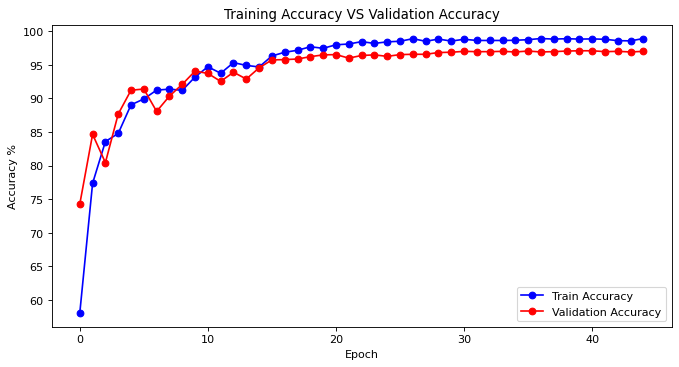

In [36]:
from matplotlib.pyplot import figure
figure(figsize=(10, 5), dpi=80)
plt.plot(range(epochs), accuracies_train, 'bo-')
plt.plot(range(epochs), accuracies_validation, 'ro-')
plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.title('Training Accuracy VS Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.show()

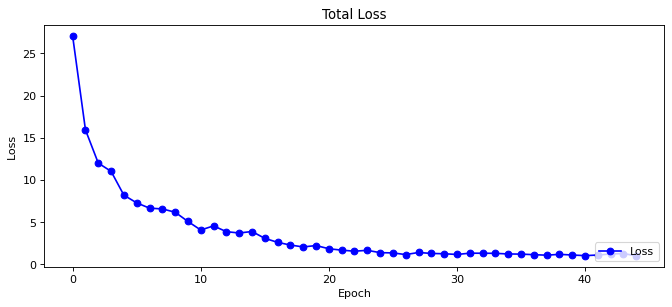

In [37]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.plot(range(epochs), total_loss, 'bo-')
plt.legend(["Loss"], loc ="lower right")
plt.title('Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss ")
plt.show()

## Evaluating the Model on the Test Set

In [38]:
from evaluate import *

In [39]:
acc, loss = evaluate(model, test_loader, criterion, device=device)

In [40]:
print(f"Testing accuracy: {acc}\nTesting loss: {loss}")

Testing accuracy: 97.10145568847656
Testing loss: 0.5761400461196899


## Calculating and Plotting the Confusion Matrix

In [41]:
y_true, y_pred = predictions(model=model, data_loader=test_loader, device=device)

In [42]:
cf_matrix = calculate_confusion_matrix(y_true=y_true, y_pred=y_pred)

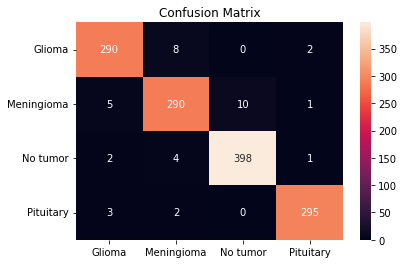

In [43]:
plot_cf_matrix(cf_matrix, dataset.classes)

## Plot Class Accuracies

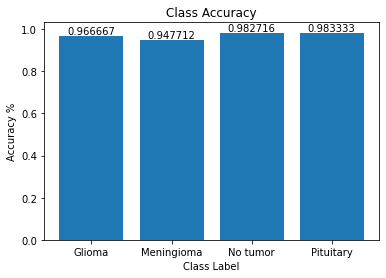

In [44]:
plot_per_class_accuracy(cf_matrix, dataset.classes)

## Classification Report

In [45]:
classification_report = get_classification_report(y_true=y_true,
                                                  y_pred=y_pred,
                                                  target_names=dataset.classes)

In [46]:
print(classification_report)

              precision    recall  f1-score   support

      Glioma       0.97      0.97      0.97       300
  Meningioma       0.95      0.95      0.95       306
    No tumor       0.98      0.98      0.98       405
   Pituitary       0.99      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [47]:
save_model(model, 'model_97_acc', os.getcwd())